In [32]:
# Core libraries for data manipulation and machine learning
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

# Keras layers and models for building the neural network
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Utilities for path operations and plotting
import pathlib
import matplotlib.pyplot as plt

In [34]:
train_dir = pathlib.Path('D:/dummy/archive/train')
test_dir = pathlib.Path('D:/dummy/archive/test')
valid_dir = pathlib.Path('D:/dummy/archive/valid')

# Data augmentation for the training set
train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, rescale=1./255)

# No data augmentation for the validation and test sets, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)



In [35]:
# Flow data from directories and apply transformations
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='sparse') # Resize images to 224x224 to match VGG16 input

valid_generator = test_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='sparse')

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='sparse')

Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


Found 15 images belonging to 3 classes.


In [37]:
#Tuning the model and training it

# Load the VGG16 model pre-trained on ImageNet data, excluding the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the convolutional base to prevent weights from being updated

 #Create a new model on top of the output of the base model
model = Sequential([base_model, Flatten(), Dense(256, activation='relu'),  Dropout(0.5), Dense(3, activation='softmax')]) #dropout for regularization to reduce overfitting. Output layer with 3 units (for 3 classes) with softmax activation. 

# Compile the model with the Adam optimizer and sparse categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks - EarlyStopping to stop training when validation loss has stopped improving
# ModelCheckpoint to save the best model based on validation loss
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1), ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', verbose=1)]

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=valid_generator, callbacks=callbacks)

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.2646 - accuracy: 0.3925
Epoch 1: val_loss improved from inf to 0.83713, saving model to best_model.h5
24/24 [==============================] - 63s 3s/step - loss: 1.2646 - accuracy: 0.3925 - val_loss: 0.8371 - val_accuracy: 0.7333
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.9768 - accuracy: 0.5175
Epoch 2: val_loss improved from 0.83713 to 0.57929, saving model to best_model.h5
24/24 [==============================] - 65s 3s/step - loss: 0.9768 - accuracy: 0.5175 - val_loss: 0.5793 - val_accuracy: 0.8667
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.7661 - accuracy: 0.6734
Epoch 3: val_loss improved from 0.57929 to 0.40977, saving model to best_model.h5
24/24 [==============================] - 64s 3s/step - loss: 0.7661 - accuracy: 0.6734 - val_loss: 0.4098 - val_accuracy: 0.9333
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.6135 - accuracy: 0.

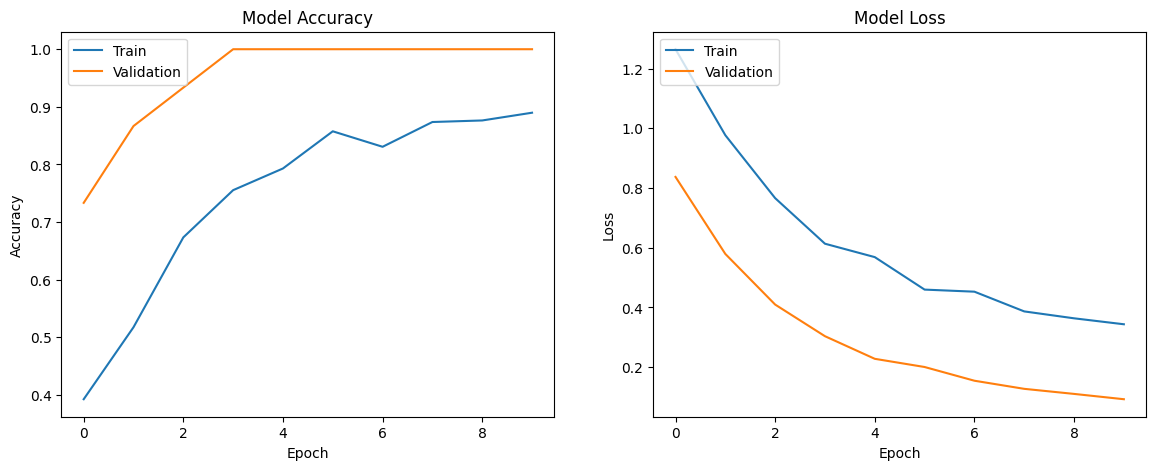

1/1 [==============================] - 1s 862ms/step - loss: 0.0907 - accuracy: 1.0000
Test Accuracy: 1.0000
Test Loss: 0.0907
1/1 [==============================] - 1s 924ms/step


In [38]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Load the best model saved by ModelCheckpoint
model.load_weights('best_model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Predict classes with the model
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.40      0.40      0.40         5
           2       0.60      0.60      0.60         5

    accuracy                           0.53        15
   macro avg       0.53      0.53      0.53        15
weighted avg       0.53      0.53      0.53        15

[[3 2 0]
 [1 2 2]
 [1 1 3]]


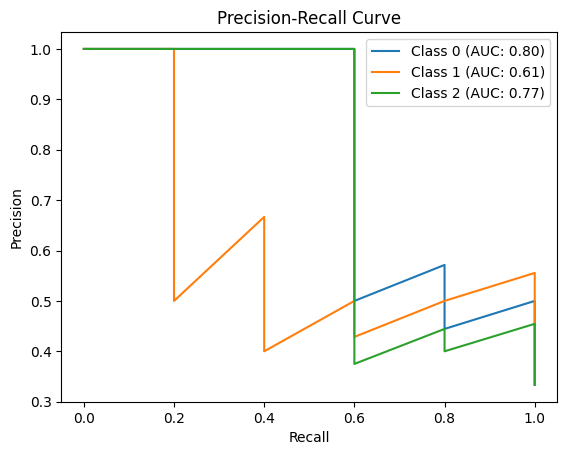

In [39]:
# Print classification report
print(classification_report(true_classes, predicted_classes))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(conf_matrix)

# Precision-Recall curve and AUC for each class
for i in range(3):
    precision, recall, _ = precision_recall_curve(true_classes == i, predictions[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AUC: {auc(recall, precision):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.title('Precision-Recall Curve')
plt.show()
